In [1]:
# data preparation + loading
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision import models
from torch import optim

# neural net
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.autograd import Variable

# general processing
from skimage import io
import matplotlib.pyplot as plt
import PIL.Image as Image

# useful tools
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

In [2]:
## confirm that current device is cuda compatible ##
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0) + " is ready and CUDA compatible")
else:
    print("Not CUDA compatible device")

NVIDIA GeForce RTX 3060 Ti is ready and CUDA compatible


In [3]:
### --- Create New annotated_truth label file --- ###
def create_annotated_truth():
    df = pd.read_csv('ISIC_2019_Training_GroundTruth.csv')
    df.to_csv('annotated_truth.csv')
    df['Category'] = 0
    df['image'] = df['image'] + '.jpg'
    for i in range(0, df.shape[0]):
        for j in range(1, 9):
            if df.iloc[i, j] == 1.0:
                df.iloc[i, 10] = j
    df.to_csv('annotated_truth.csv')
# create_annotated_truth()

In [4]:
### --- MelanomaDataset Class --- ###
class MelanomaDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return self.annotations.shape[0]
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 1])  #think this works
        image = Image.open(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 11]))
        if self.transform:
            image = self.transform(image) 
        return image, y_label

In [5]:
### --- Print first file not downloaded --- ###
def remove_missing():
    df = pd.read_csv('annotated_truth.csv')
    for i in range(len(df['image'])):
        if not os.path.exists('./data/ISIC_2019_Training_Input/ISIC_2019_Training_Input/' + df['image'][i]):
            print(df['image'][i])
            break
    print('All images are present!')       
remove_missing()

All images are present!


In [6]:
### --- Create data transforms --- ###
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.6685, 0.5300, 0.5246], [0.2228, 0.2028, 0.2145])    
])

In [7]:
### --- Create dataset --- ###
dataset = MelanomaDataset(csv_file='annotated_truth.csv',
                          root_dir='data/ISIC_2019_Training_Input/ISIC_2019_Training_Input',
                          transform=data_transforms)

In [8]:
### --- Print number of image labels we have --- ###
df = pd.read_csv('annotated_truth.csv')
print(len(df['image']))

25331


In [9]:
### --- Create train, test split; Create Dataloaders --- ###
train_set, test_set = torch.utils.data.random_split(dataset, [20265, 5066])
train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=64, shuffle=True)

In [10]:
### --- Find mean, std of dataset --- ###
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    
    for data, _ in tqdm(loader):
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum/num_batches
    std = (channels_squared_sum/num_batches - mean**2)**0.5
    
    return mean, std

# print(get_mean_std(train_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bkl nv nv nv nv nv nv nv nv bkl nv nv nv nv nv mel bcc nv mel mel nv mel bkl nv ak mel bkl bcc bkl nv bkl nv bcc df nv bkl nv mel bcc nv mel mel nv nv bkl nv scc mel mel nv nv nv nv ak bkl mel nv mel nv nv ak nv bkl bkl 

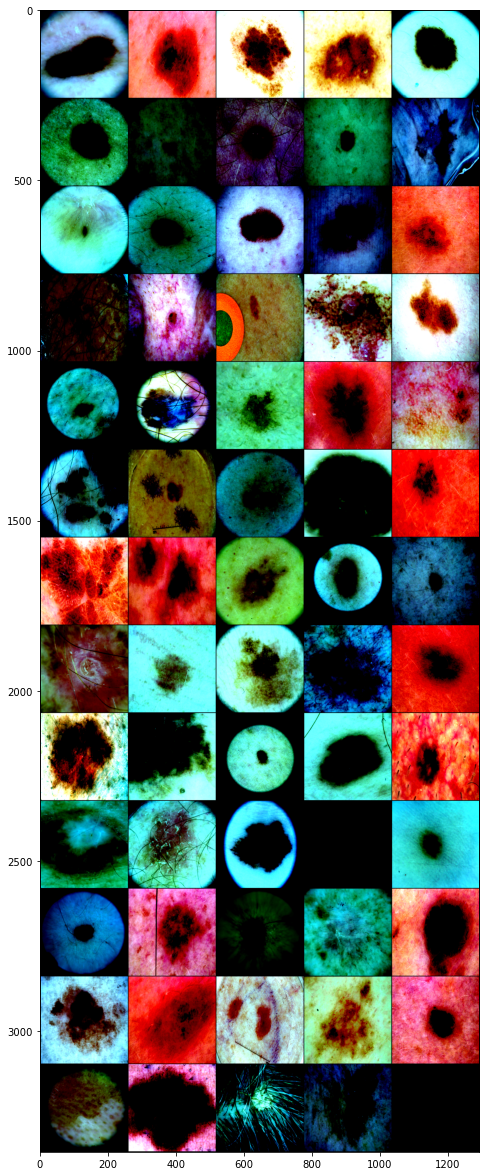

In [11]:
### --- Display labelled images in dataset --- ###

# define categories
categories = ['null', 'mel', 'nv', 'bcc', 'ak', 'bkl', 'df', 'vasc', 'scc', 'unk']

# get some random training images
dataiter = next(iter(train_loader))
images, labels = dataiter

# show images
grid = make_grid(images, nrow=5)
plt.figure(figsize=(21, 21))
plt.imshow(np.transpose(grid, (1,2,0)))
for label in labels:
    print(categories[label], end=" ")

In [12]:
# model allocation setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # set device to cuda
batch_size = 64
num_workers = 4

In [13]:
# define neural network class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, padding=0, stride=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, padding=1, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, padding=1, stride=1)
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, padding=1, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        
        self.fc1 = nn.Linear(24*14*14, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 9) # 9 image classes
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 24*14*14)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
    

net = Net()
net.to(device)
print(net)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4704, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=9, bias=True)
)


In [14]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [15]:
# define number of epochs for training
num_epochs = 8

In [16]:
tqdm._instances.clear()                             # reset tqdm
for epoch in range(num_epochs):
    running_loss = 0.0                              #initialize loss to be 0, floating point
    for i, data in enumerate(tqdm(train_loader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero our parameter gradients for training
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)                 # save the output x to outputs 
        loss = criterion(outputs, labels)     # define cross entropy loss on outputs and labels
        loss.backward()                       # backpropagation
        optimizer.step()                      # step the optimizer using gradient descent
        
        
        # print statistics
        running_loss += loss.item()
        if i % 317 == 316:    # print every epoch
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
print('Finished Training!')

100%|█████████████████████████████████████████| 317/317 [04:34<00:00,  1.16it/s]


[1,   317] loss: 0.213


100%|█████████████████████████████████████████| 317/317 [04:34<00:00,  1.15it/s]


[2,   317] loss: 0.189


100%|█████████████████████████████████████████| 317/317 [04:34<00:00,  1.15it/s]


[3,   317] loss: 0.182


100%|█████████████████████████████████████████| 317/317 [04:30<00:00,  1.17it/s]


[4,   317] loss: 0.176


100%|█████████████████████████████████████████| 317/317 [04:34<00:00,  1.15it/s]


[5,   317] loss: 0.172


100%|█████████████████████████████████████████| 317/317 [04:32<00:00,  1.16it/s]


[6,   317] loss: 0.166


100%|█████████████████████████████████████████| 317/317 [04:34<00:00,  1.15it/s]


[7,   317] loss: 0.161


100%|█████████████████████████████████████████| 317/317 [04:34<00:00,  1.15it/s]

[8,   317] loss: 0.158
Finished Training!


In [18]:
PATH = './mel-CNN.pt'
PATH2 = './mel-CNN-normalized.pt'
torch.save(net.state_dict(), PATH2)